# Telco Churn:

# Goal: 
* Discover drivers of churn at the TelcoCo telecommunications firm
* Use drivers to develop a machine learning model to predict customer churn

# Imports

In [1]:
# Standard ds imports:
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Data Prep
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

# Statistics
from scipy import stats

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.metrics import \
accuracy_score,\
recall_score,\
precision_score,\
confusion_matrix,\
classification_report

import warnings
warnings.filterwarnings("ignore")

# Custom Modules
import os
import env
import acquire
import prepare

# Acquire
Plan --> **Acquire** --> Prepare --> Explore --> Model --> Deliver

* Data acquired from 'telco_churn'
* It contained 7,043 rows and 24 columns before cleaning
* Each row represents a single customer
* Each column represents a feature the customer account

# Prepare

**Prepare Actions:**
* Removed columns with duplicate information
* Checked for nulls in the data (internet_service_type) and imputed for "No Internet Service"
* Changed dtype for 'total_charges' to float
* **Added Target column 'upset' indicating weather the lower rated player won the game**
* Reorganized 'payment_type' into values='Auto' and 'Manual'
* Encoded categorical variables
* Split data into train, validate and test (approx. 60/20/20), stratifying on 'churn'
* Outliers have not been removed for this iteration of the project

# Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|Rated| True or False, The game's result is reflected in each player's rating|
|Winning Pieces| The color of pieces the winning player was moving|
|White Rating| Rating of the player moving the white pieces using the Glicko-2 rating method for games played on Lichess|
|Black Rating| Rating of the player moving the white pieces using the Glicko-2 rating method for games played on Lichess|
|Rating Difference| The difference in rating between the players in the game|
|Game Rating| The average rating of the two players in the game|
|Lower Rated White| True or False, The lower rated player is moving the white pieces|
|Opening Name| The name of the opening played in the game|
|Time Control Group| The amount of time allotted to each player to make their moves, **Standard** (60 min or more), **Rapid** (30 - 15 min), **Blitz** (5 - 3 min), or **Bullet** (2 or less), **Other** (any other time limit)|
|Upset (Target)| True or False, The lower rated player won the game|
|Additional Features|Encoded and values for categorical data and scaled versions continuous data|


In [2]:
# acquiring data
df = acquire.get_telco_data()

# splitting data into train, validate, and test
train, validate, test = prepare.prep_telco(df)


## A brief look at the data

In [3]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_No Internet Service,mapped_payment_type_Manual
6250,Female,0,Yes,Yes,30,Yes,No,No,No,Yes,...,1,0,1,0,0,1,0,0,0,1
3458,Male,0,No,No,29,Yes,Yes,No,Yes,Yes,...,0,0,0,0,1,1,0,0,0,0
5970,Male,0,No,No,2,Yes,No,No,Yes,No,...,0,0,1,0,1,0,0,1,0,1
5861,Female,0,Yes,No,72,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,1,0,0,1,0,1,0
343,Female,0,Yes,Yes,57,Yes,No,No internet service,No internet service,No internet service,...,0,1,0,1,0,0,1,0,1,0


## A summery of the data

In [4]:
train.describe()

,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,...,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_No Internet Service,mapped_payment_type_Manual
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,...,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000
mean,0.155740,31.981302,64.567586,2245.585006,0.488757,0.482367,0.299408,0.905089,0.583195,0.265325,...,0.286391,0.215621,0.376331,0.215621,0.385089,0.208757,0.239053,0.436923,0.215621,0.570178
std,0.362651,24.472569,29.927321,2252.030630,0.499933,0.499748,0.458053,0.293127,0.493088,0.441559,...,0.452128,0.411301,0.484522,0.411301,0.486674,0.406469,0.426556,0.496064,0.411301,0.495109
min,0.000000,0.000000,18.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,35.800000,390.400000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,70.100000,1357.100000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,55.000000,89.750000,3715.650000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,72.000000,118.600000,8670.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Explore
Plan --> Acquire --> Prepare --> **Explore** --> Model --> Deliver

## Are monthly charges higher for customers who churn?

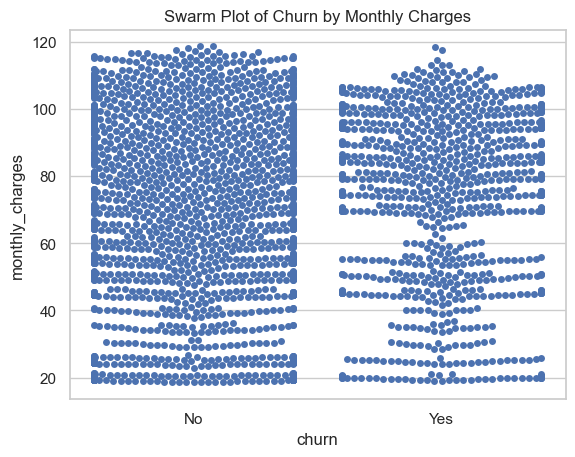

In [6]:
# Swarm Plot of Churn by Monthly Charges
# Create a swarm plot
target = 'churn'
sns.set(style="whitegrid")  # Set the style of the plot
sns.swarmplot(y='monthly_charges', x=target, data=train)

# Add labels and title
plt.ylabel('monthly_charges')
plt.xlabel(target)
plt.title('Swarm Plot of Churn by Monthly Charges')

# Show the plot
plt.show()

* It looks like there is a higher concentration of churned customers when monthly charges exceed ~$70. 

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean of monthly charges of churned customers is significantly larger than the mean monthly charges for all customers.** 

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of monthly charges of churned customers <= Mean of monthly charges of all customers.**<br>
**Ha: Mean of monthly charges of churned customers > Mean of monthly charges of all customers.**

In [8]:
alpha = 0.05
# an array of all observed values of the subgroup
churn_sample = train[train.churn == 'Yes'].monthly_charges

# the population mean
overall_mean = train.monthly_charges.mean()

t, p = stats.ttest_1samp(churn_sample, overall_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

12.86165366693209 1.0358740694591168e-35 0.05
We reject the null hypothesis.


**The alpha is less than p/2. Therefore, we have evidence to support that "Monthly Charges" and "Churn" are related. We will use monthly charges as a feature of our models.**

## Is customer churn depedent on internet service type?

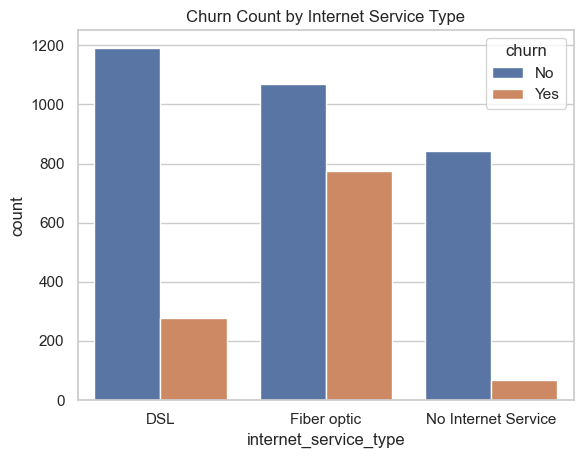

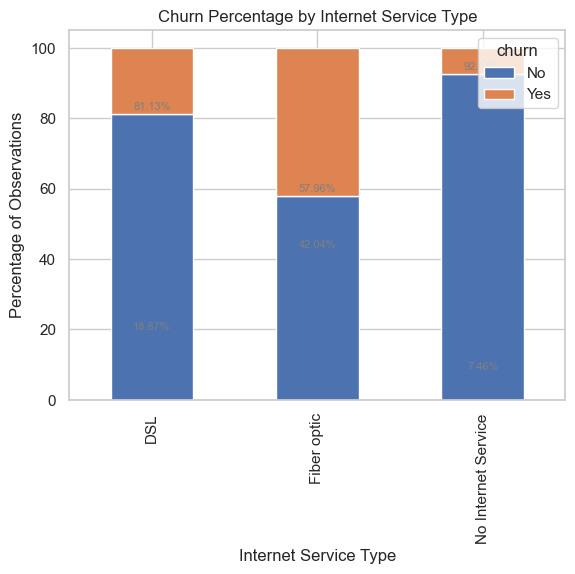

In [9]:
## Viz 1:
sns.set(style="whitegrid")
data = train
sns.countplot(x="internet_service_type", hue="churn", data=data)
plt.title("Churn Count by Internet Service Type")
plt.show()

## Viz 2:
# Calculate the percentages within each internet_service_type category
percentage_data = data.groupby('internet_service_type')['churn'].value_counts(normalize=True).unstack() * 100

# Set the style
sns.set(style="whitegrid")

# Create the bar plot
ax = percentage_data.plot(kind='bar', stacked=True)

# Set labels and title
plt.xlabel("Internet Service Type")
plt.ylabel("Percentage of Observations")
plt.title("Churn Percentage by Internet Service Type")

# Annotate with percentage values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='gray', rotation=0, xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.legend(title='churn', loc='upper right')
plt.show()

* Fiber Optic has the highest rate of churn with 42.04% of customers churning, while customers that have only phone service have the lowest rate of churn (7.46%).

**I will now use a chi-square test to investigate weather "Internet Service Type" and "Churn" are related.**
* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Customer churn rate is independent of the internet service type.** <br>
**Ha: Customer churn rate has a dependent relationship to internet service type.**

In [13]:
observed = pd.crosstab(train['internet_service_type'], train['churn'])
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print(f'p-value: {p}')
    print(f'We reject the null hypothesis.')
    print(f'There exists some relationship between Internet Service Type and the churn.')
else:
    print(f'p-value: {p}')
    print(f'We fail to reject the null hypothesis.')
    print(f'There is not a significant relationship between Internet Service Type and churn.')

p-value: 1.1586538084825805e-96
We reject the null hypothesis.
There exists some relationship between Internet Service Type and the churn.


**The p-value is less than the alpha. Therefore, we have evidence to support that "Internet Service Type" and "Churn" are related. I believe that using the "Internet Service Type" feature in modeling will likely have a positive impact on the model's accuracy.**

## Is whethere or not a customer churns independent of if they have automatic or manual payments?

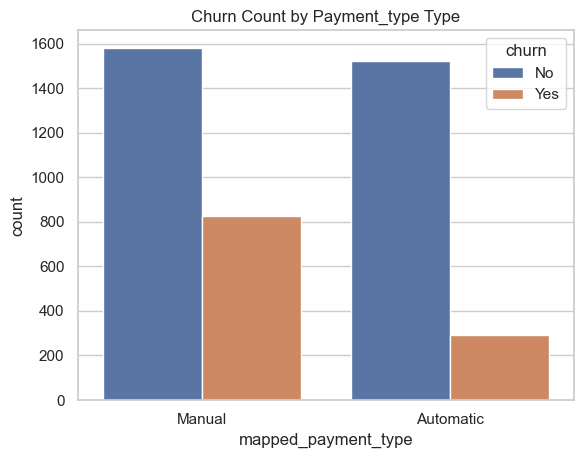

In [17]:
sns.set(style="whitegrid")
data = train
sns.countplot(x="mapped_payment_type", hue="churn", data=data)
plt.title("Churn Count by Payment_type Type")
plt.show()

* It looks like customers with manual payments churn more often than those with automatic.

**I will now do a chi-square test to test for independence between payment type and Churn.**

* I will use a confidence interval of 95%
* The resulting alpha is .05

**H0: Customer churn rate is independent of the payment type.** <br>
**Ha: Customer churn rate has a dependent relationship to payment type.**

In [18]:
observed = pd.crosstab(train['internet_service_type'], train['churn'])
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print(f'p-value: {p}')
    print(f'We reject the null hypothesis.')
    print(f'There exists some relationship between payment type and churn.')
else:
    print(f'p-value: {p}')
    print(f'We fail to reject the null hypothesis.')
    print(f'There is not a significant relationship between payment type and churn.')

p-value: 1.1586538084825805e-96
We reject the null hypothesis.
There exists some relationship between payment type and churn.


## For fiber optic customers does the addition of tech support change churn rate?


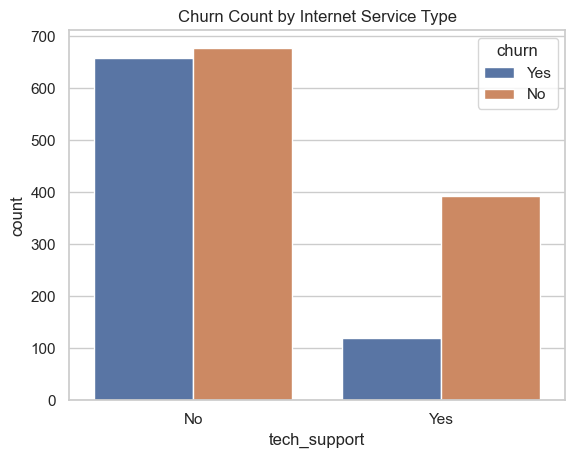

In [15]:
fiber_subset = train[train['internet_service_type'] == 'Fiber optic']

sns.countplot(x="tech_support", hue="churn", data=fiber_subset)
plt.title("Churn Count by Internet Service Type")
plt.show()

* Fiber optic customers without tech support churn roughly half the time. However, for Fiber optic customers with tech support only about 1/4 churn.

**I will now do a chi-square test to test for independence between tech support and churn for fiber optic customers.**

* I will use a confidence interval of 95%
* The resulting alpha is .05

**H0: Fiber optic customer churn is independent on tech support.** <br>
**Ha: Fiber optic customer churn is dependent on tech support.**

In [16]:
observed = pd.crosstab(fiber_subset.churn, fiber_subset.tech_support)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print(f'p-value: {p}')
    print(f'We reject the null hypothesis.')
    print(f'There exists some relationship between tech support and the churn.')
else:
    print(f'p-value: {p}')
    print(f'We fail to reject the null hypothesis.')
    print(f'There is not a significant relationship between tech support and churn.')

p-value: 6.625286470594788e-24
We reject the null hypothesis.
There exists some relationship between tech support and the churn.


**The p-value is less than the alpha. Therefore, we have evidence to support that churn rate for Fiber optic customers with tech support is significantly different than the churn rate for Fiber optic customers without tech support. Based on this, I believe that using "tech support" during modeling will provide an improvement in the model's accuracy.** 

# Exploration Summary

* "Monthly Charges" and "Internet Service Type" were each found to be drivers of "Churn"
    * Likely a moderate/strong relation ship to each
* "Payment Type" was found to be a driver of "Churn"
* "Tech Support" was found to be a driver of "Churn" 
    * Tech Support was only analyzed on customers with Fiber Optic as Fiber Optic had the largest percentage of "Churn"
<br>

# Features I am moving to modeling With
* "Monthly Charges"
* "Internet Service Type" 
* "Payment Type"
* "Tech Support"

# Features I'm not moving to modeling with
* 

In [25]:
features1 = ['monthly_charges',
       'tech_support_No internet service', 'tech_support_Yes',
       'internet_service_type_Fiber optic',
       'internet_service_type_No Internet Service',
       'mapped_payment_type_Manual']

# Modeling
Plan --> Acquire --> Prepare --> Explore --> **Model** --> Deliver
* I will use accuracy as my evaluation metric  
* non-churns makeup 73.47% of the training data 
 <br>
* by guessing "No" for 'churn' for every customer one could achieve an accuracy of 73.47%
* 73.47%% will be the baseline accuracy I use for this project
 <br>
* I will be evaluating models developed using three different model types and various hyperparameter configurations 
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data 

In [26]:
# prep data for modeling
X_train, y_train = \
train[features1], \
train[target]

X_validate, y_validate = \
validate[features1], \
validate[target]

X_test, y_test = \
test[features1], \
test[target]

## Decision Tree

In [31]:
def get_tree(X_train, X_validate, y_train, y_validate):
    '''get decision tree accuracy on train and validate data'''

    # create classifier object
    clf = DecisionTreeClassifier(max_depth=5, random_state=666)

    #fit model on training data
    clf = clf.fit(X_train, y_train)

    # print result
    print(f"Accuracy of Decision Tree on train data is {clf.score(X_train, y_train)}")
    print(f"Accuracy of Decision Tree on validate data is {clf.score(X_validate, y_validate)}")

In [30]:
get_tree(X_train, X_validate, y_train, y_validate)

Accuracy of Decision Tree on train data is 0.7685207100591716
Accuracy of Decision Tree on validate data is 0.7565649396735273


* Decision Tree outperformed the baseline by about 3%.

## KNN

In [42]:
def get_knn(X_train, X_validate, y_train, y_validate):
    '''get KNN accuracy on train and validate data'''

    # create model object and fit it to the training data
    knn = KNeighborsClassifier(n_neighbors=20, weights='uniform')
    knn.fit(X_train, y_train)

    # print results
    print(f"Accuracy of KNN on train is {knn.score(X_train, y_train)}")
    print(f"Accuracy of KNN on validate is {knn.score(X_validate, y_validate)}")

In [43]:
get_knn(X_train, X_validate, y_train, y_validate)

Accuracy of KNN on train is 0.7815384615384615
Accuracy of KNN on validate is 0.7487579843860894


* Logistic regression outperformed baseline by about 5% on train, but only about 1% on validate.


## Logistic Regression

In [44]:
def get_reg(X_train, X_validate, y_train, y_validate):
    '''get logistic regression accuracy on train and validate data'''

    # create model object and fit it to the training data
    logit = LogisticRegression(solver='liblinear')
    logit.fit(X_train, y_train)

    # print result
    print(f"Accuracy of Logistic Regression on train is {logit.score(X_train, y_train)}")
    print(f"Accuracy of Logistic Regression on validate is {logit.score(X_validate, y_validate)}")

In [45]:
get_reg(X_train, X_validate, y_train, y_validate)

Accuracy of Logistic Regression on train is 0.7623668639053255
Accuracy of Logistic Regression on validate is 0.7601135557132718


* Logistic regression outperformed baseline by about 3% for both train and validate.

# Comparing Models

* Decision Tree, Random Forest, and Logistic Regression models all performed about equal to baseline on train and validate
* The KNN model performed slightly better on train data but was worse on validate data. It is likely overfit.
* Because the results of the Decision Tree, Random Forest, and Logistic Regression models were all very similar I could proceed to test with any of these models.
* I have chosen to move forward with the Logistic Regression model

## Logistic Regression on Test

In [47]:
def get_reg_test(X_train, X_test, y_train, y_test):
    '''get logistic regression accuracy on train and validate data'''

    # create model object and fit it to the training data
    logit = LogisticRegression(solver='liblinear')
    logit.fit(X_train, y_train)

    # print result
    print(f"Accuracy of Logistic Regression on test is {logit.score(X_test, y_test)}")

In [49]:
# get test results for final model
get_reg_test(X_train, X_test, y_train, y_test)

Accuracy of Logistic Regression on test is 0.7750177430801988


### Modeling Summary

* The KNN model performed the best on the training set, but worst on the validate set.
* Decision Tree model and Logistic Regression model performed similarly, both about 3% higher than baseline.
* A Logistic Regression model selected as the final model as the difference between train performance and validate performance was lowest.

# Conclusions

### Exploration

* Upsets in chess occur in about 1/3 of games
* Games in which the lower rated player makes the first move, and games that are rated have a slightly higher chance of ending in an upset 
* Games ending in upset have a much lower mean difference in player rating than games not ending in upset
* Games using shorter time control, such as Bullet, Blitz, and Rapid games, have an upset percentage that closely mirrors the overall upset percentage ranging from 30-34% while standard games have a much lower upset percentage at 22%
* Looking at the top 10 openings in terms of frequency in the data set we can conclude that a given opening does affect the likelihood of a game ending in an upset. Upset percentages very by opening from 20-39%
* The average rating of players in a game has no provable effect on the chance of that game ending in upset

### Modeling

**The final model only outperformed baseline by ~3%. Possible reason:**
* In an effort to maximize interpretability and inform business strategy only the features that could be most easily targetted through business intervention were included. Because of this only a few features were included.

### Recommendations

* Include tech support for all Fiber optic customers.
* Encourage customers to enroll in automatic payments. (i.e. rebate for enrollment)

### Next Steps
* Prescriptive Model: Identify the features that would be easiest for the business to take action. Then create a model using those features to find where executives can focus to lower churn rate.
* Predictive Model: further EDA to find significant relationships for all potential features. Then create a model using all of the significant features.